# Crypto Analysis

We aim to study the correlations between Bitcoin closing prices and the input features: Twitter sentiment scores, Google Trends and volume of Bitcoins traded.

In [1]:
import pandas as pd
import numpy as np
from scipy.stats import *
import matplotlib.pyplot as plt
import plotly.graph_objs as go

from datetime import datetime

# Package installation for financial visulizations
#!pip install --upgrade mplfinance
# import mplfinance as mpf

plt.style.use('seaborn')
blue = '#3949AB'
orange = 'darkorange'
green = 'forestgreen'
%matplotlib inline

#### Prepare the Bitcoin datasets

In [2]:
btc_path_min = '../data/crypto/BTCUSDT_1m_data.csv'
btc_path_hour = '../data/crypto/BTCUSDT_1h_data.csv'
columns_to_use = ['timestamp', 'open', 'high', 'low', 'close', 'volume']
# Minutely BTC
btc_min = pd.read_csv(btc_path_min, usecols=columns_to_use)
df_btc_m = btc_min.copy()
# Hourly BTC
btc_hour = pd.read_csv(btc_path_hour, usecols=columns_to_use)
df_btc_h = btc_hour.copy()

df_btc_m.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150524 entries, 0 to 150523
Data columns (total 6 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   timestamp  150524 non-null  object 
 1   open       150524 non-null  float64
 2   high       150524 non-null  float64
 3   low        150524 non-null  float64
 4   close      150524 non-null  float64
 5   volume     150524 non-null  float64
dtypes: float64(5), object(1)
memory usage: 6.9+ MB


In [3]:
# Convert to datetime and set date as index
# Minutely
df_btc_m['timestamp'] = pd.to_datetime(df_btc_m['timestamp'])
df_btc_m = df_btc_m.rename(columns = {'timestamp': 'date'}).set_index('date')
# Hourly
df_btc_h['timestamp'] = pd.to_datetime(df_btc_h['timestamp'])
df_btc_h = df_btc_h.rename(columns={'timestamp': 'date'}).set_index('date')

df_btc_m.head(3)

open      high       low     close     volume
date                                                                  
2021-01-01 00:00:00  28923.63  28961.66  28913.12  28961.66  27.457032
2021-01-01 00:01:00  28961.67  29017.50  28961.01  29009.91  58.477501
2021-01-01 00:02:00  29009.54  29016.71  28973.58  28989.30  42.470329

Now, we have a lot of data here that it will be helpful in the future. But now we just want to build a preliminary project with toy data, so let's take a look at the longest volume traded in the time of study.. **Same dates as twitter extraction sample we got earlier.** <br> Let's do it baby!

In [4]:
df_btc_h.head(2)

open      high       low     close       volume
date                                                                    
2021-01-01 00:00:00  28923.63  29031.34  28690.17  28995.13  2311.811445
2021-01-01 01:00:00  28995.13  29470.00  28960.35  29409.99  5403.068471

### Bitcoin closing prices first visualization

In [5]:
df = df_btc_h[(df_btc_h.index >= '2021-02-21 00:00:00') & (df_btc_h.index <= '2021-03-20 23:50:31')]
fig = go.Figure(data=[go.Candlestick(x=df.index,
                open=df['open'],
                high=df['high'],
                low=df['low'],
                close=df['close'])])
fig.update_layout(xaxis_rangeslider_visible=False)
fig.show()

# Twitter sentiment analysis scores (with VADER)

### Groupbies and sum by time frames

In [6]:
tweets_path = '../data/twitter/scored_tweets.csv'

tweets = pd.read_csv(tweets_path)
df_tweets = tweets.copy()
df_tweets['date'] = pd.to_datetime(df_tweets['date'])
df_tweets = df_tweets[(df_tweets['date'] >= '2021-02-21') & (df_tweets['date'] <= '2021-03-21')]
df_tweets.set_index('date', inplace=True)
print(df_tweets.info())
df_tweets.head(3)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1508479 entries, 2021-02-21 00:00:00 to 2021-03-20 23:50:31
Data columns (total 7 columns):
 #   Column          Non-Null Count    Dtype  
---  ------          --------------    -----  
 0   id              1508479 non-null  int64  
 1   text            1508478 non-null  object 
 2   followers       1508479 non-null  int64  
 3   likes           1508479 non-null  int64  
 4   vader_polarity  1508479 non-null  float64
 5   emotion         1508479 non-null  object 
 6   vader_score     1508479 non-null  float64
dtypes: float64(2), int64(3), object(2)
memory usage: 92.1+ MB
None


id  \
date                              
2021-02-21  1363277252306358275   
2021-02-21  1363277252557955072   
2021-02-21  1363277252633354242   

                                                         text  followers  \
date                                                                       
2021-02-21  RT : Join the Airdrop to get a share of 5 mill...         49   
2021-02-21  RT : Because not everyone knows: If Bitcoin’s ...        127   
2021-02-21  RT : In 24 hours I’m going to give one random ...         11   

            likes  vader_polarity   emotion  vader_score  
date                                                      
2021-02-21      0          0.5267  Positive      2.58083  
2021-02-21      0          0.0516  Positive      0.65532  
2021-02-21      0          0.0000   Neutral      0.00000

In [7]:
minutely_vader_scores = df_tweets.resample('min')[['vader_polarity', 'vader_score']].sum()
hourly_vader_scores = df_tweets.resample('h')[['vader_polarity', 'vader_score']].sum()


print(minutely_vader_scores.head())
print('*' * 50)
print(hourly_vader_scores.head())

                     vader_polarity  vader_score
date                                            
2021-02-21 00:00:00         43.8765  53938.34267
2021-02-21 00:01:00         27.2732  -4157.33769
2021-02-21 00:02:00         43.4384   1480.53613
2021-02-21 00:03:00          5.3143   4327.68297
2021-02-21 00:04:00          0.0000      0.00000
**************************************************
                     vader_polarity   vader_score
date                                             
2021-02-21 00:00:00        342.3618  154319.02855
2021-02-21 01:00:00        342.1027  102026.76434
2021-02-21 02:00:00        377.8373  182005.34381
2021-02-21 03:00:00        217.3936   62987.43980
2021-02-21 04:00:00        339.2160  117490.73592


### Polarity & main scores visualization

Text(0.5, 0.98, 'Sentiment Scores & Polarity of Bitcoin tweets')

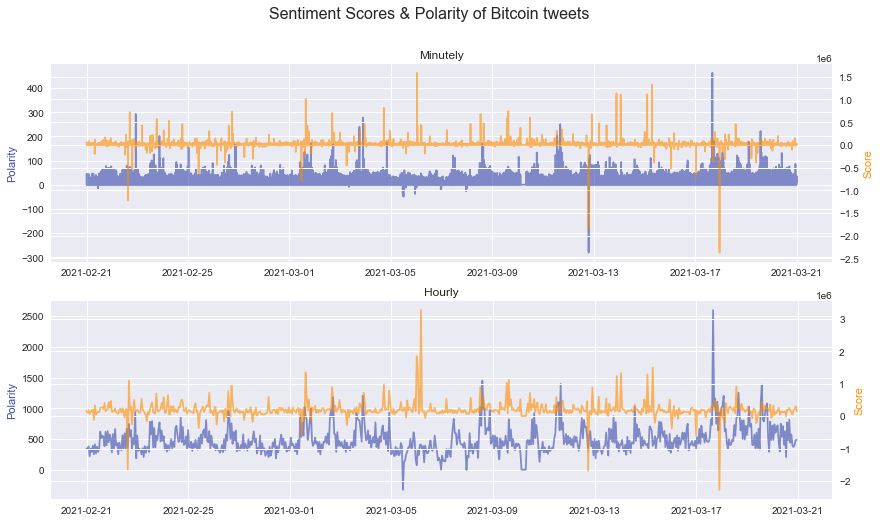

In [8]:
plt.style.use('seaborn')

fig, axes = plt.subplots(2, 1, figsize=(14, 8))
# VADER plot (minutely)
axes[0].set_title('Minutely')
ax1 = axes[0].twinx()
axes[0].plot(minutely_vader_scores.index, minutely_vader_scores['vader_polarity'], blue, alpha=0.6)
ax1.plot(minutely_vader_scores.index, minutely_vader_scores['vader_score'], orange, alpha=0.6)
axes[0].set_ylabel('Polarity', color=blue)
ax1.set_ylabel('Score', color=orange)

# VADER plot (hourly)
axes[1].set_title('Hourly')
ax2 = axes[1].twinx()
axes[1].plot(hourly_vader_scores.index, hourly_vader_scores['vader_polarity'], blue, alpha=0.6)
ax2.plot(hourly_vader_scores.index, hourly_vader_scores['vader_score'], orange, alpha=0.6)
axes[1].set_ylabel('Polarity', color=blue)
ax2.set_ylabel('Score', color=orange)

fig.suptitle('Sentiment Scores & Polarity of Bitcoin tweets', fontsize=16)

It looks like there are, a few outstanding both positive and negative outliers in VADER scores.

## Minutely analysis

#### Data merging

In [9]:
# Reduce bitcoin df length to match
df_btc_m = df_btc_m[(df_btc_m.index >= df_tweets.index.min()) & (df_btc_m.index <= df_tweets.index.max())]

# And merge
data_m = pd.merge(df_btc_m, minutely_vader_scores, right_index=True, left_index=True)
data_m.head(3)

open      high       low     close      volume  \
date                                                                      
2021-02-21 00:00:00  55841.19  55987.97  55822.33  55885.13  134.205366   
2021-02-21 00:01:00  55882.34  55899.83  55622.30  55748.36  117.877839   
2021-02-21 00:02:00  55754.73  55850.00  55731.33  55745.63   87.712717   

                     vader_polarity  vader_score  
date                                              
2021-02-21 00:00:00         43.8765  53938.34267  
2021-02-21 00:01:00         27.2732  -4157.33769  
2021-02-21 00:02:00         43.4384   1480.53613

In [10]:
# Remove outliers from VADER score
# For performance purposes we remove 1 max. & 2 min. outliers
# Correlation is stronger this way
data_m['vader_no_outliers'] = data_m['vader_score'].replace([data_m['vader_score'].min()],
                                                             data_m['vader_score'].mean())

data_m['vader_no_outliers'] = data_m['vader_no_outliers'].replace([data_m['vader_no_outliers'].min()],
                                                                   data_m['vader_score'].mean())

data_m['vader_no_outliers'] = data_m['vader_no_outliers'].replace([data_m['vader_no_outliers'].max()],
                                                                   data_m['vader_score'].mean())

In [11]:
# We create a new dataframe with useful columns
data_m = (
    data_m.drop(labels=['open', 'high', 'low', 'vader_polarity', 'vader_score'], axis=1)
          .rename(columns={'vader_no_outliers': 'vader_score'})
)
data_m.head()

close      volume  vader_score
date                                                  
2021-02-21 00:00:00  55885.13  134.205366  53938.34267
2021-02-21 00:01:00  55748.36  117.877839  -4157.33769
2021-02-21 00:02:00  55745.63   87.712717   1480.53613
2021-02-21 00:03:00  55826.06   59.355978   4327.68297
2021-02-21 00:04:00  55700.00   63.994262      0.00000

#### Plot it

Text(0.5, 0.98, 'Minutely overview')

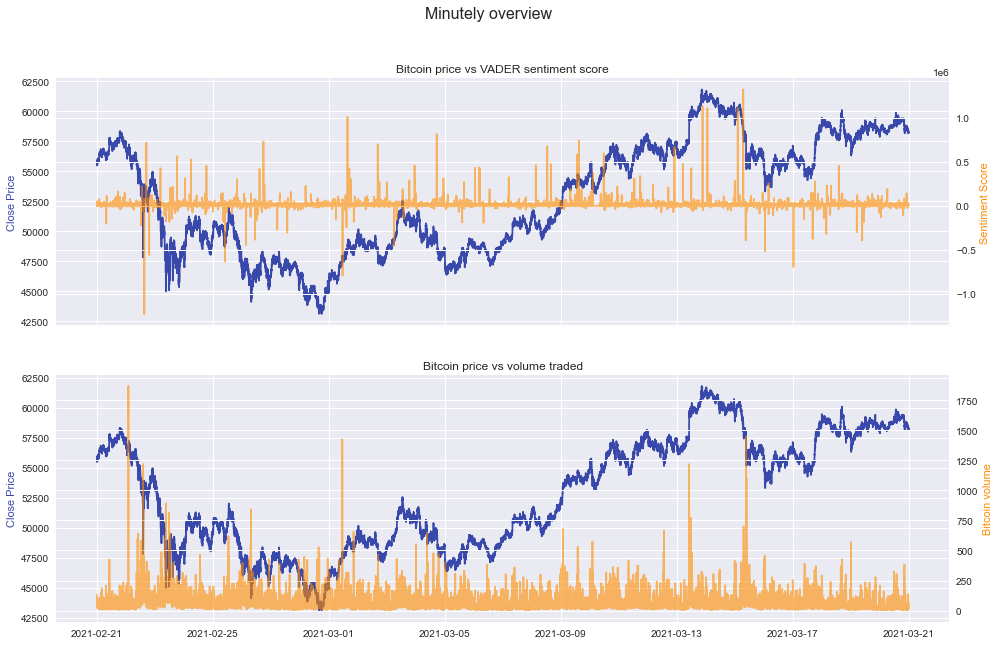

In [12]:
fig, axes = plt.subplots(2, 1, figsize=(16, 10), sharex=True)
# Bitcoin price vs VADER sentiment score
axes[0].set_title('Bitcoin price vs VADER sentiment score')
ax1 = axes[0].twinx()
axes[0].plot(data_m.index, data_m['close'], blue)
ax1.plot(data_m.index, data_m['vader_score'], orange, alpha=0.6)
axes[0].set_ylabel('Close Price', color=blue)
ax1.set_ylabel('Sentiment Score', color=orange)

# Bitcoin price vs volume traded
axes[1].set_title('Bitcoin price vs volume traded')
ax2 = axes[1].twinx()
axes[1].plot(data_m.index, data_m['close'], blue)
ax2.plot(data_m.index, data_m['volume'], orange, alpha=0.6)
axes[1].set_ylabel('Close Price', color=blue)
ax2.set_ylabel('Bitcoin volume', color=orange)

fig.suptitle('Minutely overview', fontsize=16)

#### Correlation among columns

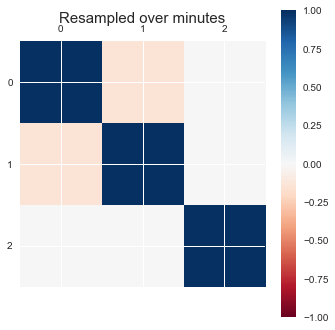

In [17]:
# Correlations among columns
plt.matshow(data_m.corr(method='spearman'),vmax=1,vmin=-1,cmap='RdBu')
plt.title('Resampled over minutes', size=15)
plt.colorbar()
plt.show()

This heatmap shows almost no correlation between the features. We need to check if there is any lag between people posting tweets and the actual price changing. We set a lag of 300 minutes which is equivalent to 5 hours.

We are going to calculate correlation coefficients between:
1. Bitcoin close prices and VADER sentiment scores.
2. Bitcoin close prices and volume of Bitcoin traded.

In [23]:
# Defining some functions
def corr_coef(x, y, method, lag=0):
    """It returns a correlation coeficient.
    
    Parameters
    -----------
    x : pandas.Series
    y : pandas.Series
    method : 'pearson' , 'spearman', 'kendall'
    lag : number of desire lags"""
    
    return x.corr(y.shift(lag), method)


def plot_coef(coefs, range_, name):
    """Plots linear chart given a corr coefficient and a specific range.
    
    Parameters
    ----------
    coefs : list of coefficients
    range_ : range
    name : str. Coefficient name"""
    plt.figure(figsize=(8, 4))
    plt.plot(coefs, range_, color=blue, label=name)
    plt.title(f'{name} Correlation Coefficient')
    plt.xlabel('Lag')
    plt.ylabel('Correlation')
    plt.legend()

1. Bitcoin close prices and VADER sentiment scores

In [24]:
# Defining some variables
x = data_m['vader_score']
y = data_m['close']
minutely_range = range(-60*5, 60*5)

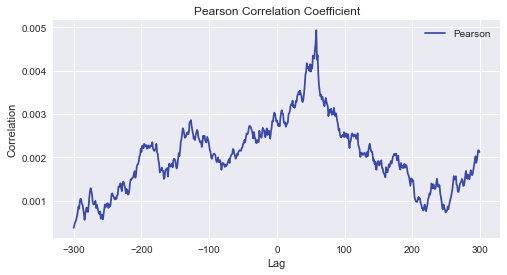

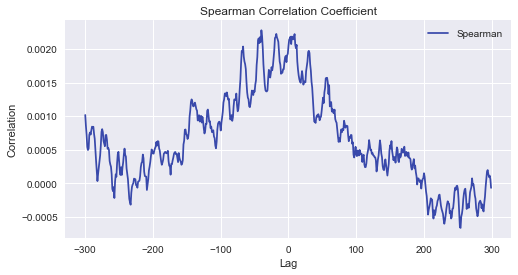

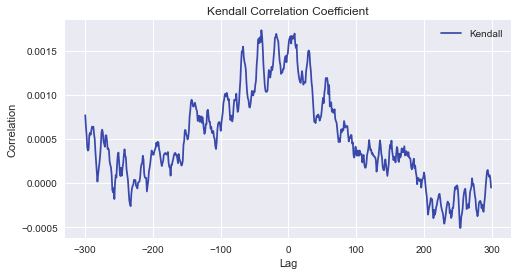

In [25]:
coef = [corr_coef(x, y, 'pearson', lag=lag) for lag in minutely_range]
plot_coef(minutely_range, coef, 'Pearson')

coef = [corr_coef(x, y, 'spearman', lag=lag) for lag in minutely_range]
plot_coef(minutely_range, coef, 'Spearman')

coef = [corr_coef(x, y, 'kendall', lag=lag) for lag in minutely_range]
plot_coef(minutely_range, coef, 'Kendall')

2. Bitcoin close prices and volume of Bitcoin traded

In [26]:
# Defining some variables
x = data_m['volume']
y = data_m['close']
minutely_range = range(-60*5, 60*5)

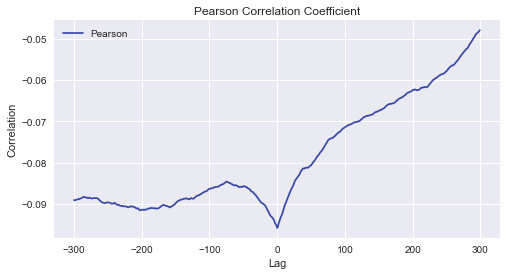

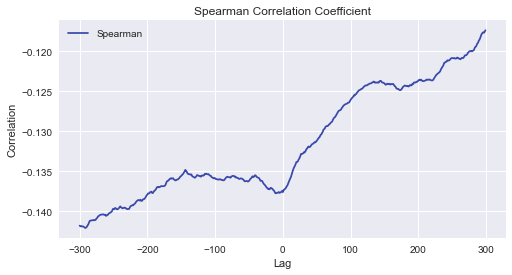

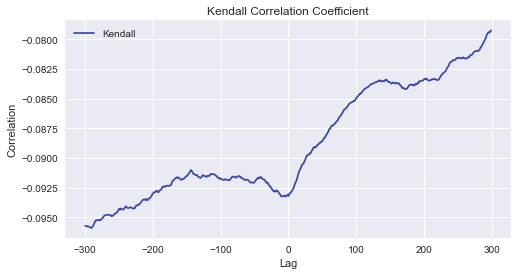

In [27]:
coef = [corr_coef(x, y, 'pearson', lag=lag) for lag in minutely_range]
plot_coef(minutely_range, coef, 'Pearson')

coef = [corr_coef(x, y, 'spearman', lag=lag) for lag in minutely_range]
plot_coef(minutely_range, coef, 'Spearman')

coef = [corr_coef(x, y, 'kendall', lag=lag) for lag in minutely_range]
plot_coef(minutely_range, coef, 'Kendall')

Adding lags when checking correlation, does not change much. Correlations are still nearly 0 for data resampled over minutes.

## Hourly Analysis

#### Google trends feature

For hourly aggregated data we got Google trends on Bitcoin. Refer to the extraction notebook. We will add the feature to our analysis.

In [28]:
btc_trends = pd.read_csv('../data/google_trends/bitcoin_trends.csv',
                         parse_dates=True,
                         names=['date', 'g_trends'],
                         skiprows=1,
                         index_col='date')
btc_trends.info()
btc_trends.head()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 701 entries, 2021-02-21 00:00:00 to 2021-03-22 00:00:00
Data columns (total 1 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   g_trends  701 non-null    int64
dtypes: int64(1)
memory usage: 11.0 KB


g_trends
date                         
2021-02-21 00:00:00        72
2021-02-21 01:00:00        72
2021-02-21 02:00:00        72
2021-02-21 03:00:00        73
2021-02-21 04:00:00        75

In [29]:
# Merge 
data_h = pd.merge(df_btc_h, hourly_vader_scores, right_index=True, left_index=True)
data_h = pd.merge(data_h, btc_trends, right_index=True, left_index=True)
data_h.info()
data_h.head()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 677 entries, 2021-02-21 00:00:00 to 2021-03-20 23:00:00
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   open            677 non-null    float64
 1   high            677 non-null    float64
 2   low             677 non-null    float64
 3   close           677 non-null    float64
 4   volume          677 non-null    float64
 5   vader_polarity  677 non-null    float64
 6   vader_score     677 non-null    float64
 7   g_trends        677 non-null    int64  
dtypes: float64(7), int64(1)
memory usage: 47.6 KB


open      high       low     close       volume  \
date                                                                       
2021-02-21 00:00:00  55841.19  56061.64  55477.59  55834.95  2949.777561   
2021-02-21 01:00:00  55834.95  56351.08  55717.87  56347.69  2125.263288   
2021-02-21 02:00:00  56347.70  56660.94  56253.77  56318.08  2201.031649   
2021-02-21 03:00:00  56318.08  56900.00  56311.40  56505.22  2027.220197   
2021-02-21 04:00:00  56505.22  56725.12  56040.31  56701.08  2060.642337   

                     vader_polarity   vader_score  g_trends  
date                                                         
2021-02-21 00:00:00        342.3618  154319.02855        72  
2021-02-21 01:00:00        342.1027  102026.76434        72  
2021-02-21 02:00:00        377.8373  182005.34381        72  
2021-02-21 03:00:00        217.3936   62987.43980        73  
2021-02-21 04:00:00        339.2160  117490.73592        75

In [30]:
# Remove outliers from VADER score
# We remove 1 max. & 2 min. outliers
data_h['vader_no_outliers'] = data_h['vader_score'].replace([data_h['vader_score'].min()],
                                                             data_h['vader_score'].mean())

data_h['vader_no_outliers'] = data_h['vader_no_outliers'].replace([data_h['vader_no_outliers'].min()],
                                                                   data_h['vader_score'].mean())

data_h['vader_no_outliers'] = data_h['vader_no_outliers'].replace([data_h['vader_no_outliers'].max()],
                                                                   data_h['vader_score'].mean())

In [31]:
# We create a new dataframe with useful columns
data_h = (
    data_h.drop(labels=['open', 'high', 'low', 'vader_polarity', 'vader_score'], axis=1)
          .rename(columns={'vader_no_outliers': 'vader_score'})
)
data_h.head()

close       volume  g_trends   vader_score
date                                                              
2021-02-21 00:00:00  55834.95  2949.777561        72  154319.02855
2021-02-21 01:00:00  56347.69  2125.263288        72  102026.76434
2021-02-21 02:00:00  56318.08  2201.031649        72  182005.34381
2021-02-21 03:00:00  56505.22  2027.220197        73   62987.43980
2021-02-21 04:00:00  56701.08  2060.642337        75  117490.73592

#### Plot it

Text(0.5, 0.98, 'Hourly overview')

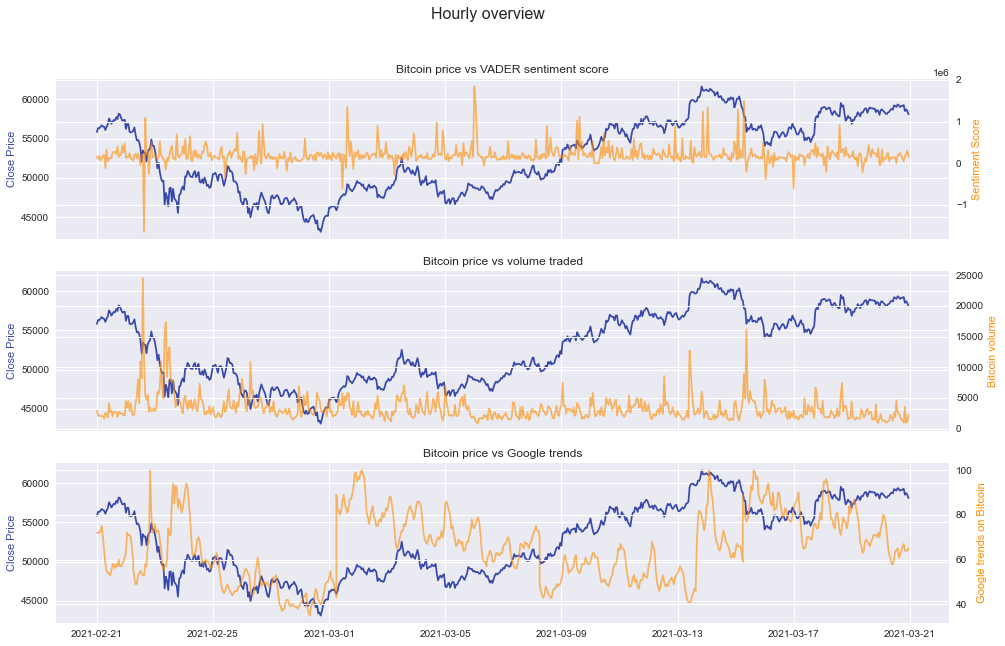

In [32]:
plt.style.use('seaborn')

fig, axes = plt.subplots(3, 1, figsize=(16, 10), sharex=True)
# Bitcoin price vs VADER sentiment score
axes[0].set_title('Bitcoin price vs VADER sentiment score')
ax1 = axes[0].twinx()
axes[0].plot(data_h.index, data_h['close'], blue)
ax1.plot(data_h.index, data_h['vader_score'], orange, alpha=0.6)
axes[0].set_ylabel('Close Price', color=blue)
ax1.set_ylabel('Sentiment Score', color=orange)

# Bitcoin price vs volume traded
axes[1].set_title('Bitcoin price vs volume traded')
ax2 = axes[1].twinx()
axes[1].plot(data_h.index, data_h['close'], blue)
ax2.plot(data_h.index, data_h['volume'], orange, alpha=0.6)
axes[1].set_ylabel('Close Price', color=blue)
ax2.set_ylabel('Bitcoin volume', color=orange)

# Bitcoin price vs Google trends on Bitcoin
axes[2].set_title('Bitcoin price vs Google trends')
ax3 = axes[2].twinx()
axes[2].plot(data_h.index, data_h['close'], blue)
ax3.plot(data_h.index, data_h['g_trends'], orange, alpha=0.6)
axes[2].set_ylabel('Close Price', color=blue)
ax3.set_ylabel('Google trends on Bitcoin', color=orange)

fig.suptitle('Hourly overview', fontsize=16)

#### Correlation among columns

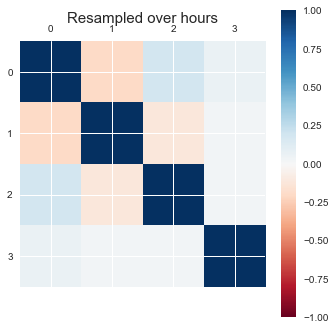

In [33]:
# Correlations among columns
plt.matshow(data_h.corr(method='spearman'), vmax=1, vmin=-1, cmap='RdBu')
plt.title('Resampled over hours', size=15)
plt.colorbar()
plt.show()

There is almost no correlation. We will try to add some lags and see the results. 30 hours of lag

We are going to calculate correlation coefficients between:

1. Bitcoin close prices and VADER sentiment scores.
2. Bitcoin close prices and volume of Bitcoin traded.
3. Bitcoin close prices and Google trends on Bitcoin

1. Bitcoin close prices and VADER sentiment scores.

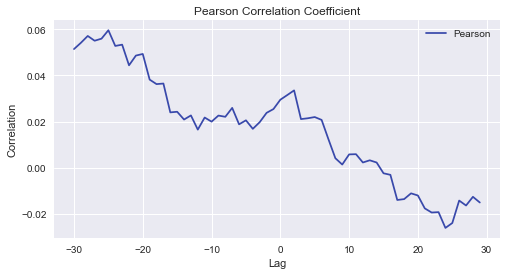

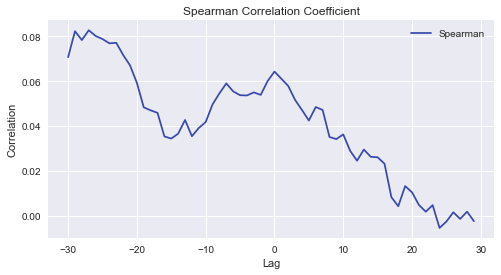

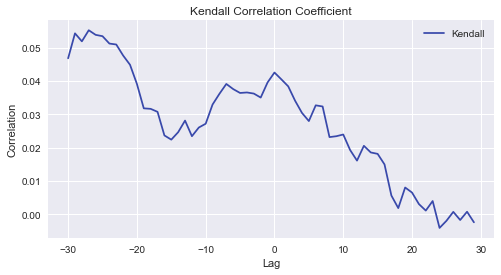

In [34]:
# Defining some variables
x = data_h['vader_score']
y = data_h['close']
hourly_range = range(-30, 30)

coef = [corr_coef(x, y, 'pearson', lag=lag) for lag in hourly_range]
plot_coef(hourly_range, coef, 'Pearson')

coef = [corr_coef(x, y, 'spearman', lag=lag) for lag in hourly_range]
plot_coef(hourly_range, coef, 'Spearman')

coef = [corr_coef(x, y, 'kendall', lag=lag) for lag in hourly_range]
plot_coef(hourly_range, coef, 'Kendall')

2. Bitcoin close prices and volume of Bitcoin traded.

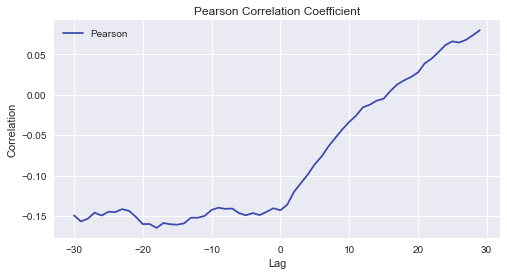

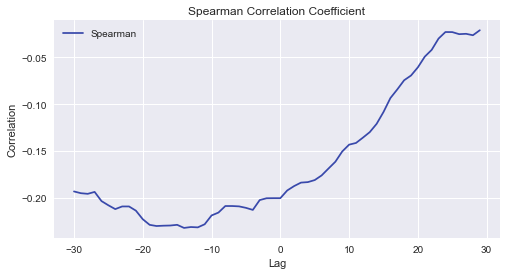

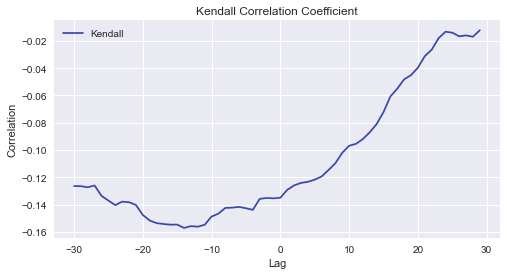

In [35]:
# Defining some variables
x = data_h['volume']
y = data_h['close']
hourly_range = range(-30, 30)

coef = [corr_coef(x, y, 'pearson', lag=lag) for lag in hourly_range]
plot_coef(hourly_range, coef, 'Pearson')

coef = [corr_coef(x, y, 'spearman', lag=lag) for lag in hourly_range]
plot_coef(hourly_range, coef, 'Spearman')

coef = [corr_coef(x, y, 'kendall', lag=lag) for lag in hourly_range]
plot_coef(hourly_range, coef, 'Kendall')

3. Bitcoin close prices and Google trends on Bitcoin

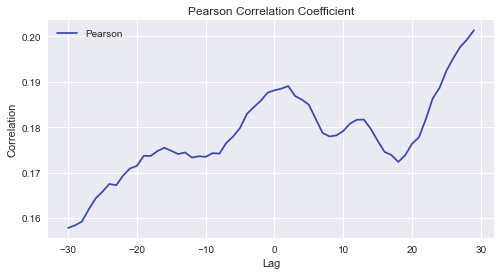

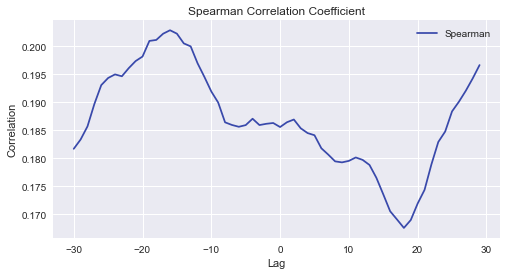

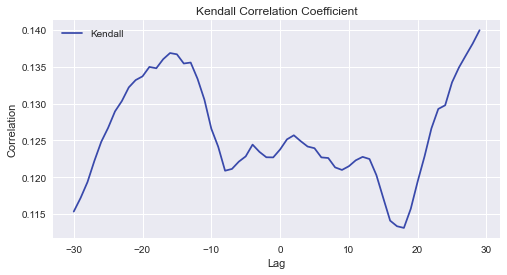

In [36]:
# Defining some variables
x = data_h['g_trends']
y = data_h['close']
hourly_range = range(-30, 30)

coef = [corr_coef(x, y, 'pearson', lag=lag) for lag in hourly_range]
plot_coef(hourly_range, coef, 'Pearson')

coef = [corr_coef(x, y, 'spearman', lag=lag) for lag in hourly_range]
plot_coef(hourly_range, coef, 'Spearman')

coef = [corr_coef(x, y, 'kendall', lag=lag) for lag in hourly_range]
plot_coef(hourly_range, coef, 'Kendall')

It looks like features are (slightly) more correlated when data is hourly aggregated, so we will try to make predictions with data aggregated by hour in next notebooks.

It also can be seen that sometimes there is more correlation in negative lags than in positive. This would mean that these features do not influence Bitcoin prices but Bitcoin prices have an impact on them.

In [28]:
# # Save feature datasets for prediction purposes
# # Hourly
# data_h.to_csv('../data/hourly_features.csv')
# # Minutely
# data_m.to_csv('../data/minutely_features.csv')